通过200代的基因进化，精英染色体出现在第3代，基因序列为：
a,b,c,h,f,g,e,d,a
精英染色体映射的最短路径为：14.714776642118863


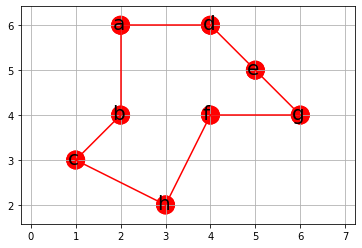

In [1]:
'''
TSP—启发式遗传算法
1、种群初始化编码问题
2、适应度打分函数
3、选择操作：优秀染色体被选中的概率和适应度函数成正比
4、交叉操作：一对染色体的基因片段杂交
5、变异操作：单个染色体的基因片段变异
6、进化逆转操作：单个染色体的基因片段
7、进化论：适者生存，优胜劣汰
'''
import numpy as np
import matplotlib.pyplot as plt
# 距离函数
def distance(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))
# 种群初始化编码(生成基因的随机排列)
def init_chromos(start=-1, gene_len=-1):
    chroms = []  # 所有种群
    for i in range(population_num):
        gene = list(range(gene_len))  # 染色体基因编码
        np.random.shuffle(gene)
        # 调换染色体的头部基因为给定的基因
        if start != -1:
            for j, g in enumerate(gene):
                if g == start:
                    gene[0], gene[j] = gene[j], gene[0]
        chroms.append(gene)
    return chroms
# 适应度打分函数，返回该染色体的适应度(优秀)分数
def calc_fin_ness(citys, gens):
    gens = np.copy(gens)
    gens = np.append(gens, gens[0])  # 在染色体的末尾添加上头部基因
    D = np.sum([distance(citys[gens[i]], citys[gens[i+1]]) for i in range(len(gens) - 1)])
    return 1.0 / D
# 赌徒转盘(精英染色体被选中的概率与适应度函数打分的结果成正比)
def roulette_gambler(fit_pros, chroms):
    pick = np.random.random()
    for j in range(len(chroms)):
        pick -= fit_pros[j]
        if pick <= 0:
            return j
    return 0
# 染色体选择操作(通过适应度函数打分和赌徒转盘，来选择出精英染色体)
def choice(citys, chroms):
    n = len(chroms)
    fit_pros = []
    [fit_pros.append(calc_fin_ness(citys, chroms[i])) for i in range(n)]
    choice_gens = []
    for i in range(n):
        j = roulette_gambler(fit_pros, chroms)  # 采用赌徒转盘选择出一个更好的染色体
        choice_gens.append(chroms[j])  # 选中一个染色体
    for i in range(n):
        chroms[i] = choice_gens[i]  # 优胜劣汰，替换出更精英的染色体
    return chroms
# 染色体交叉操作(两个染色体互相杂交基因片段，用于产生新的染色体，影响全局寻优能力)
def cross(chroms):
    gens_len = len(chroms[0])
    move = 0  # 当前基因移动的位置
    while move < gens_len - 1:
        cur_pro = np.random.random()  # 决定是否进行交叉操作
        # 本次不进行交叉操作
        if cur_pro > cross_pro:
            move += 2
            continue
        parent1, parent2 = move, move + 1  # 准备杂交的两个染色体(种群)
        index1 = np.random.randint(1, gens_len - 2)
        index2 = np.random.randint(index1, gens_len - 2)
        if index1 == index2:
            continue
        temp_gen1 = chroms[parent1][index1:index2+1]  # 交叉的基因片段1
        temp_gen2 = chroms[parent2][index1:index2+1]  # 交叉的基因片段2
        # 杂交插入染色体片段
        temp_parent1, temp_parent2 = np.copy(chroms[parent1]).tolist(), np.copy(chroms[parent2]).tolist()
        temp_parent1[index1:index2+1] = temp_gen2
        temp_parent2[index1:index2+1] = temp_gen1
        # 消去冲突
        pos = index1 + len(temp_gen1)  # 插入杂交基因片段的结束位置
        conflict1_ids, conflict2_ids = [], []
        [conflict1_ids.append(i) for i, v in enumerate(temp_parent1) if v in temp_parent1[index1:pos]
         and i not in list(range(index1, pos))]
        [conflict2_ids.append(i) for i, v in enumerate(temp_parent2) if v in temp_parent2[index1:pos]
         and i not in list(range(index1, pos))]
        for i, j in zip(conflict1_ids, conflict2_ids):
            temp_parent1[i], temp_parent2[j] = temp_parent2[j], temp_parent1[i]
        chroms[parent1] = temp_parent1
        chroms[parent2] = temp_parent2
        move += 2
    return chroms
# 变异操作(随机调换单个染色体的基因位置)
def mutation(chroms):
    n = len(chroms)
    gens_len = len(chroms[0])
    for i in range(n):
        cur_pro = np.random.random()  # 决定是否进行变异操作
        # 本次不进行变异操作
        if cur_pro > mutation_pro:
            continue
        index1 = np.random.randint(1, gens_len - 2)
        index2 = np.random.randint(1, gens_len - 2)
        chroms[i][index1], chroms[i][index2] = chroms[i][index2], chroms[i][index1]
    return chroms
# 逆转操作(让单个染色体逆转之后变得更加优秀)
def reverse(citys, chroms):
    n = len(chroms)
    gens_len = len(chroms[0])
    for i in range(n):
        flag = 0
        while flag == 0:
            index1 = np.random.randint(1, gens_len - 2)
            index2 = np.random.randint(index1, gens_len - 2)
            if index1 == index2:
                continue
            temp_chrom = np.copy(chroms[i])
            temp_chrom = temp_chrom.tolist()
            temp_gen = temp_chrom[index1:index2+1]
            temp_gen.reverse()
            temp_chrom[index1:index2 + 1] = temp_gen
            fit_score1 = calc_fin_ness(citys, chroms[i])
            fit_score2 = calc_fin_ness(citys, temp_chrom)
            # 说明经过逆转操作后的染色体将变得更加优秀
            if fit_score2 > fit_score1:
                chroms[i] = temp_chrom  # 更新染色体为逆转染色体
            flag = 1
    return chroms
# 可视化画出哈密顿回路
def draw_H(citys, best_gens):
    H_path = []
    [H_path.append((cur_gen, best_gens[i+1])) for i, cur_gen in enumerate(best_gens[:-1])]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.2, color='red')
        p2 = plt.Circle(citys[to_], 0.2, color='red')
        ax.add_patch(p1)
        ax.add_patch(p2)
        ax.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='red')
        ax.annotate(s=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)
    ax.axis('equal')
    ax.grid()
    plt.show()
if __name__ == '__main__':
    max_evolution_num = 200  # 最大进化代数
    population_num = 100  # 种群数目
    cross_pro = 0.6  # 交叉概率
    mutation_pro = 0.1  # 变异概率
    citys = [(2, 6), (2, 4), (1, 3), (4, 6), (5, 5), (4, 4), (6, 4), (3, 2)]  # 城市坐标
    best_gens = [-1 for _ in range(len(citys))]  # 精英染色体(基因排列)
    min_distance = np.inf  # 最短路径长度
    best_fit_index = 0  # 最短路径出现的代数
    start = 0  # 种群的初始位置
    # 开始达尔文进化
    for step in range(max_evolution_num):
        distance_arr = []  # 每一个染色体的总路程数组
        chroms = init_chromos(start=start, gene_len=len(citys))  # 种群初始化，得到所有种群
        chroms = choice(citys, chroms)  # 选择操作，选择出每个种群的精英染色体
        chroms = cross(chroms)  # 交叉操作，两个染色体互相杂交产生新的染色体
        chroms = mutation(chroms)  # 变异操作，单个染色体变异
        chroms = reverse(citys, chroms)  # 变异操作，单个染色体变得更加优秀
        [distance_arr.append(1.0 / calc_fin_ness(citys, chroms[i])) for i in range(len(chroms))]
        best_gens_idx = np.argmin(distance_arr)  # 找到最短的路径位置，对应于精英染色体位置
        if distance_arr[best_gens_idx] < min_distance:
            min_distance = distance_arr[best_gens_idx]  # 更新最短路径
            best_gens = chroms[best_gens_idx]  # 更新精英染色体
            best_gens.append(start)
            best_fit_index += 1  # 更新最短路径出现的代数
    print('通过{}代的基因进化，精英染色体出现在第{}代，基因序列为：'.format(max_evolution_num, best_fit_index))
    [print(chr(97 + v), end=',' if i < len(best_gens) - 1 else '\n') for i, v in enumerate(best_gens)]
    print('精英染色体映射的最短路径为：{}'.format(min_distance))
    draw_H(citys, best_gens)